## **1. Dataset**

We use a synthetic dataset simulating weekly chicken sales, incorporating a trend, seasonal pattern (higher sales during summer), and noise. We also add two additional features: temperature (which may impact sales) and promotions (binary indicator).

> **Interpretation**:  
> The dataset is designed to mimic real-world behavior where chicken sales might increase during warmer periods (summer) and when promotions are active. By including these variables, we ensure that our model can potentially learn from both time-dependent (seasonality) and external (temperature, promotions) factors.


In [374]:
#import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [375]:
# Read the .csv file and create a dataframe
df = pd.read_csv('Chicken_Sales_Dataset.csv', parse_dates=['Date'])

# Indexing with the date column
df.set_index('Date', inplace=True)

# Display the dataframe
df.head()

,Chicken_Sales,Temperature,Promotions
Date,,,
2020-01-05,112.483571,22.705463,0
2020-01-12,109.549063,16.141781,1
2020-01-19,113.719212,17.271131,0
2020-01-26,118.336303,16.908004,0
2020-02-02,117.111280,19.963037,1


## **2. Exploratory Data Analysis (EDA)**

> **Interpretation**:  
> Visualizing the time series data allows us to observe the overall trend and identify any clear seasonal patterns. Here, we expect to see fluctuations corresponding to the monthly cycle (seasonality) and an upward trend due to a simulated increase in chicken sales over time. This step is crucial for understanding the nature of the time series before applying models.


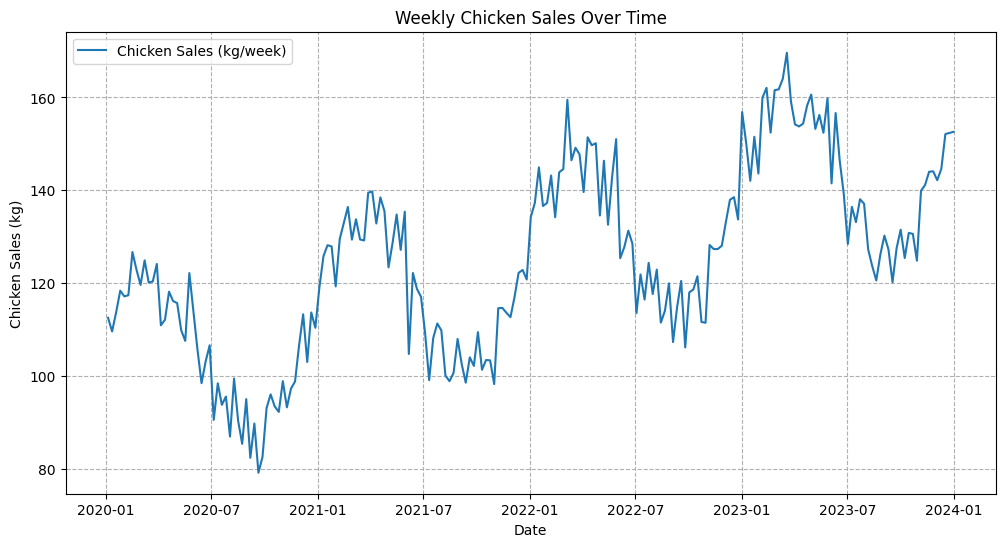

In [376]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Chicken_Sales'], label='Chicken Sales (kg/week)')
plt.title('Weekly Chicken Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Chicken Sales (kg)')
plt.grid(True, linestyle='--') 
plt.legend()
plt.show()


## **3. Stationarity Check**

> **Interpretation**:  
> The Augmented Dickey-Fuller (ADF) test is used to check if the series is stationary. For ARIMA models to perform well, the data should be stationary. If the series is non-stationary (p-value > 0.05), we may need to difference it.  
> 
> **Why stationarity matters**:  
> A stationary series has constant mean and variance over time, making it predictable using past values. If the series shows a trend or seasonality, differencing (using d = 1) helps in removing these patterns.  
> 
> **Temperature and Promotions**:  
> We also check these variables as they might be used later in multivariate models (VAR). Ensuring these are stationary is essential for reliable model fitting.


In [397]:
def adf_test(series, name):
    result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value for {name}: {result[1]}')
    if result[1] < 0.05:
        print(f'The {name} series is stationary.\n')
    else:
        print(f'The {name} series is not stationary.\n')

# Perform ADF test on each variable
#adf_test(df['Chicken_Sales'], 'Chicken Sales')
#adf_test(df['Temperature'], 'Temperature')
adf_test(df['Promotions'], 'Promotions')


ADF Statistic for Chicken Sales: -3.2074724018893312
p-value for Chicken Sales: 0.019556201210699647
The Chicken Sales series is stationary.

ADF Statistic for Temperature: -7.885734953460747
p-value for Temperature: 4.575198214864449e-12
The Temperature series is stationary.

ADF Statistic for Promotions: -5.473439653188918
p-value for Promotions: 2.3704570167682385e-06
The Promotions series is stationary.



## **4. ARIMA Modeling**

### 4.1 Determine ARIMA Parameters

> **Interpretation**:  
> We plot the ACF and PACF to determine the appropriate `p` (AR term) and `q` (MA term).  
> - **ACF (Autocorrelation Function)** shows how each lag correlates with the series. Significant lags indicate a moving average (MA) component (`q`).  
> - **PACF (Partial Autocorrelation Function)** reveals the lags of the autoregressive (AR) term (`p`). Significant spikes suggest the inclusion of AR terms.

> **Choice Justification**:  
> Based on the plots, we select initial values for `p` and `q`. For example, if the PACF plot shows a sharp drop after lag 3, we set \( p = 3 \). However, there isn't a specific spike at any log, it suggests a higher-order MA model \( q = 12 \).



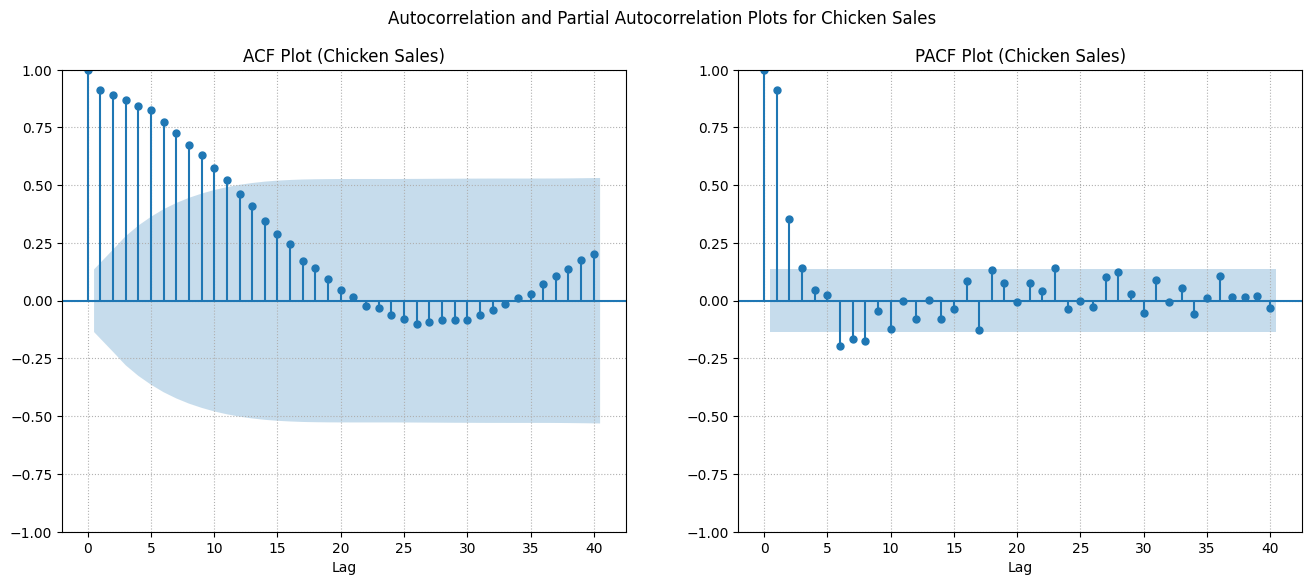

In [378]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Chicken_Sales'], lags=40, ax=axes[0])
axes[0].set_title('ACF Plot (Chicken Sales)')
axes[0].set_xlabel('Lag')
axes[0].grid(True, linestyle='dotted')  # Add grid to the first plot
plot_pacf(df['Chicken_Sales'], lags=40, ax=axes[1])
axes[1].set_title('PACF Plot (Chicken Sales)')
axes[1].set_xlabel('Lag')
axes[1].grid(True, linestyle='dotted')  # Add grid to the second plot
fig.suptitle('Autocorrelation and Partial Autocorrelation Plots for Chicken Sales')
plt.show()

### 4.2 Fit ARIMA Model

> **Interpretation**:  
> We fit the ARIMA model with the selected parameters `(p, d, q)`. Here, `d` is set to 0 if the ADF test indicated the series is stationary. If not, we set `d = 1` to difference the series.

> **Model Summary**:  
> The summary includes coefficients for AR and MA components, and their significance levels. We interpret these coefficients to understand how past values and errors influence the current value.

In [ ]:
# Fit ARIMA model
arima_model = ARIMA(df['Chicken_Sales'], order=(4, 0, 12))
arima_result = arima_model.fit()

# Display model summary
print(arima_result.summary())


### 4.3 Forecasting with ARIMA

> **Interpretation**:  
> We use the ARIMA model to forecast the next 12 weeks of chicken sales based on the parameters determined earlier. The forecast is then compared against "true" values that we generate to simulate real-world behavior. We also plot confidence intervals to visualize the uncertainty of our predictions.

> **Choice Justification**:  
> - **Forecast Steps**: We choose a forecast horizon of 12 weeks to provide a reasonable timeframe for short-term business planning, such as inventory management or marketing strategies.
> - **True Values**: These are generated with a slight trend, seasonality, and random noise to simulate real-world fluctuations, making our forecast evaluation realistic.

> **Plot Analysis**:  
> - The plot shows historical chicken sales, the ARIMA forecast, and the invented true values for comparison.  
> - The shaded area represents the confidence intervals, providing a range of expected values for the forecasted weeks. If the true values fall within these intervals, it suggests that the model performs well and captures the underlying patterns in the data.  
> - A close alignment between forecasted and true values indicates that the ARIMA model is a suitable choice for this time series, given the identified parameters.



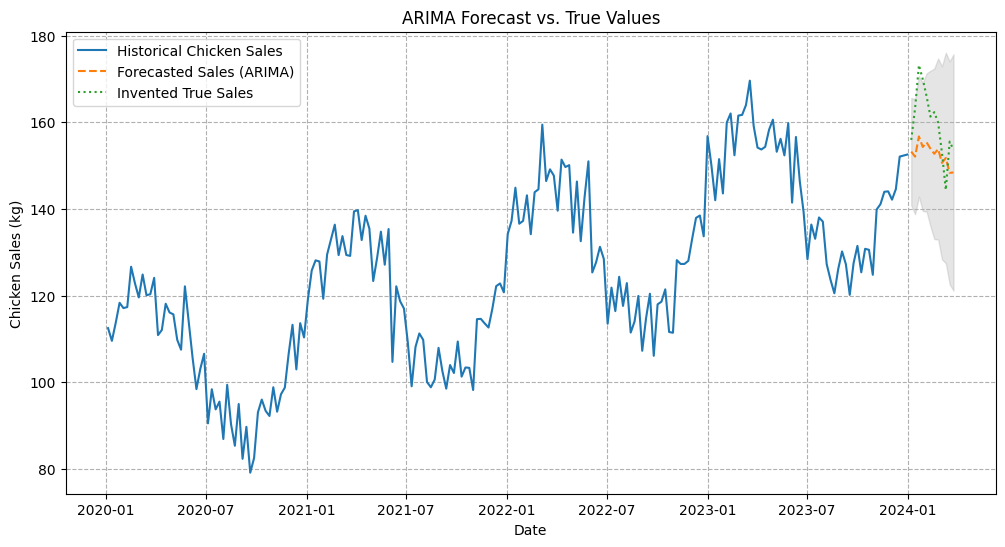

In [380]:
forecast_steps = 12
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Invent true values for comparison
true_values = df['Chicken_Sales'].iloc[-1] + np.linspace(1, 10, forecast_steps) + 15 * np.sin(2 * np.pi * np.arange(forecast_steps) / 12) + np.random.normal(0, 5, forecast_steps)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Chicken_Sales'], label='Historical Chicken Sales')
plt.plot(forecast_values.index, forecast_values, label='Forecasted Sales (ARIMA)', linestyle='--')
plt.plot(forecast_values.index, true_values, label='Invented True Sales', linestyle=':')
plt.fill_between(forecast_values.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.2)
plt.title('ARIMA Forecast vs. True Values')
plt.xlabel('Date')
plt.ylabel('Chicken Sales (kg)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

## **5. VAR Modeling**

### 5.1 Fit VAR Model

> **Interpretation**:  
> VAR (Vector AutoRegression) is suitable for multivariate time series where multiple variables (like temperature and promotions) influence the target variable (chicken sales).  
> - We use the **AIC (Akaike Information Criterion)** to determine the optimal number of lags.  
> - VAR models are more comprehensive as they account for interactions between multiple time series.

> **Choice Justification**:  
> We choose the maximum lags (`maxlags=15`) initially, and the model automatically selects the best lag based on AIC. This method ensures that we capture sufficient information from past values without overfitting.



In [ ]:
# Fit VAR model
var_model = VAR(df[['Chicken_Sales', 'Temperature', 'Promotions']])
var_result = var_model.fit(maxlags=15, ic='aic')

# Display summary
print(var_result.summary())




### 5.2 Forecasting with VAR

> **Interpretation**:  
> We forecast the next 12 weeks using the VAR model and compare it to the invented true values. We evaluate if including additional variables improves the forecast accuracy compared to the univariate ARIMA model.

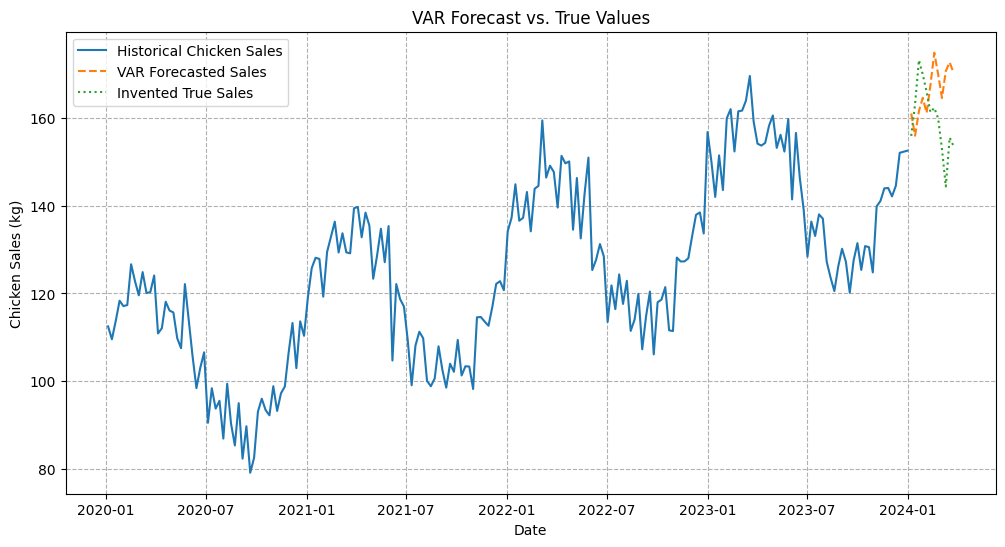

In [382]:
# Forecast the next 12 weeks
var_forecast = var_result.forecast(df[['Chicken_Sales', 'Temperature', 'Promotions']].values[-var_result.k_ar:], steps=12)
var_forecast_df = pd.DataFrame(var_forecast, index=pd.date_range(start=df.index[-1] + pd.Timedelta(weeks=1), periods=12, freq='W'), columns=['Chicken_Sales', 'Temperature', 'Promotions'])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Chicken_Sales'], label='Historical Chicken Sales')
plt.plot(var_forecast_df.index, var_forecast_df['Chicken_Sales'], label='VAR Forecasted Sales', linestyle='--')
plt.plot(var_forecast_df.index, true_values, label='Invented True Sales', linestyle=':')
plt.title('VAR Forecast vs. True Values')
plt.xlabel('Date')
plt.ylabel('Chicken Sales (kg)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


## **6. SARIMA Modeling**

SARIMA extends ARIMA by incorporating a seasonal component to account for patterns recurring at specific intervals (e.g., yearly seasonality for weekly data).

### 6.1 Fit SARIMA Model

> **Interpretation**:  
> We choose an initial SARIMA configuration: `(p, d, q)(P, D, Q, m)`, where:
> - `(p, d, q)` represents the non-seasonal part.
> - `(P, D, Q, m)` captures the seasonal elements, with `m = 52` for annual seasonality in weekly data.
> 
> **Choice Justification**:  
> The parameters `P` and `Q` mirror the non-seasonal components but are adjusted for the seasonal pattern (every 52 weeks).  
> - We set `D = 0` if the seasonal pattern is stationary; otherwise, `D = 1` to difference it.

> **Model Summary**:  
> The SARIMA model summary provides information about both the non-seasonal and seasonal components, helping us understand if the seasonal part significantly contributes to the model.




In [ ]:
# Fit SARIMA model
sarima_model = SARIMAX(df['Chicken_Sales'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 52), enforce_stationarity=False, enforce_invertibility=False)
sarima_result = sarima_model.fit()

# Summary
print(sarima_result.summary())

### 6.2 Forecasting with SARIMA

> **Interpretation**:  
> We forecast the next 12 weeks and visualize the confidence intervals to understand the uncertainty in the predictions.  
> - If the forecast closely aligns with the invented true values, it indicates that including seasonality was beneficial.  
> - The width of the confidence interval provides insight into the model’s confidence and stability.

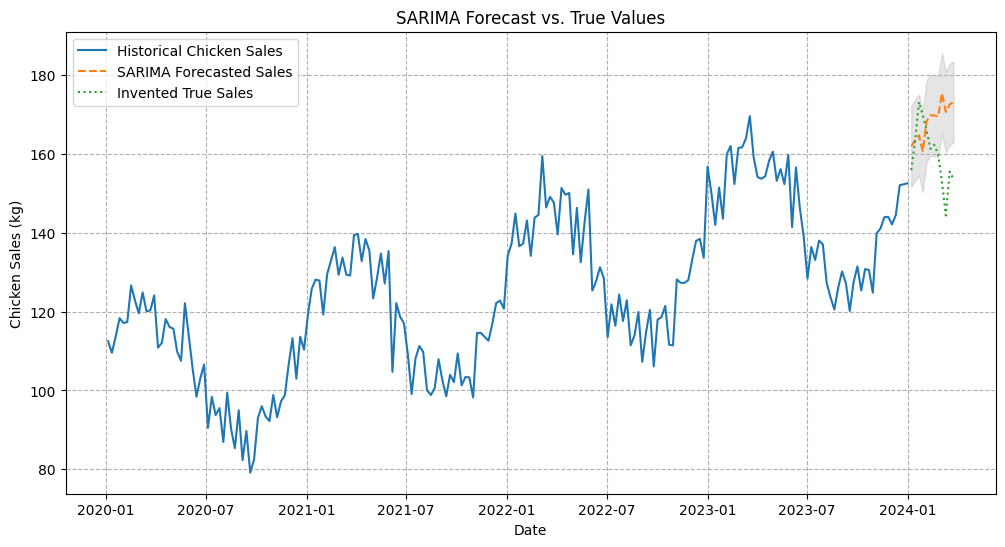

In [384]:
sarima_forecast = sarima_result.get_forecast(steps=12)
sarima_forecast_values = sarima_forecast.predicted_mean
sarima_forecast_conf_int = sarima_forecast.conf_int()

# Plot SARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Chicken_Sales'], label='Historical Chicken Sales')
plt.plot(sarima_forecast_values.index, sarima_forecast_values, label='SARIMA Forecasted Sales', linestyle='--')
plt.plot(sarima_forecast_values.index, true_values, label='Invented True Sales', linestyle=':')
plt.fill_between(sarima_forecast_values.index, sarima_forecast_conf_int.iloc[:, 0], sarima_forecast_conf_int.iloc[:, 1], color='gray', alpha=0.2)
plt.title('SARIMA Forecast vs. True Values')
plt.xlabel('Date')
plt.ylabel('Chicken Sales (kg)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


## **7. Model Evaluation and Comparison**

> **Interpretation**:  
> We compare ARIMA, VAR, and SARIMA models using metrics like MAE (Mean Absolute Error), MSE (Mean Squared Error), and RMSE (Root Mean Squared Error).  
> - **MAE**: Measures average absolute deviation from true values, providing a direct measure of accuracy.  
> - **MSE**: Penalizes larger errors more heavily, giving insight into overall model fit.  
> - **RMSE**: Square root of MSE, interpretable in the same units as the data.

> **Choice Justification**:  
> - **ARIMA**: Suitable when chicken sales depend mainly on past values without seasonal effects.  
> - **VAR**: Incorporates additional variables like temperature and promotions to see if they improve predictive power.  
> - **SARIMA**: Adds seasonality when we observe repeated patterns (e.g., yearly cycles).  
> 
> The best model is selected based on the lowest error metrics, with AIC/BIC values also guiding parameter selection.


In [396]:

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate and display metrics for each model
def evaluate_forecast(true_vals, forecast_vals):
    mae = mean_absolute_error(true_vals, forecast_vals)
    mse = mean_squared_error(true_vals, forecast_vals)
    rmse = np.sqrt(mse)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

arima_metrics = evaluate_forecast(true_values, forecast_values)
var_metrics = evaluate_forecast(true_values, var_forecast_df['Chicken_Sales'])
sarima_metrics = evaluate_forecast(true_values, sarima_forecast_values)

print('ARIMA Metrics:')
print(arima_metrics)
print('\nVAR Metrics:')
print(var_metrics)
print('\nSARIMA Metrics:')
print(sarima_metrics)


ARIMA Metrics:
{'MAE': np.float64(8.487104307167222), 'MSE': np.float64(90.41428749683216), 'RMSE': np.float64(9.508642778905523)}

VAR Metrics:
{'MAE': np.float64(11.244921939703916), 'MSE': np.float64(164.1858682774071), 'RMSE': np.float64(12.813503356904665)}

SARIMA Metrics:
{'MAE': np.float64(11.444539161778932), 'MSE': np.float64(190.91538122289765), 'RMSE': np.float64(13.817213222024826)}


The ARIMA model currently performs the best among the models tested. Further fine-tuning could be conducted to improve its accuracy and optimize its performance even more.


### Conclusion

This notebook demonstrates the process of forecasting retail sales using various time series models, such as ARIMA, VAR, and SARIMA. However, it is important to note that the results presented here are based on artificially generated ground truth values, which limits the validity and objectivity of the model performance comparisons. In a real-world scenario, accurate and reliable data is essential to objectively evaluate and determine the best model.

In practice, when dealing with real and sufficient data, the approach demonstrated in this notebook serves as a robust framework for time series analysis and forecasting. It highlights how different models can be used to capture various patterns, such as seasonality and multivariate relationships, to improve the accuracy of predictions.

### Future Directions

To further explore and improve the accuracy of time series forecasting, advanced methods such as **Recurrent Neural Networks (RNN)**, specifically using the **LSTM (Long Short-Term Memory)** architecture, can be applied. LSTM networks are particularly suited for time series data as they effectively handle long-term dependencies and patterns, which are often present in complex time series datasets.

By leveraging these advanced techniques, one can achieve more accurate and meaningful forecasts, provided that high-quality and well-prepared data is available.
